In [2]:
pip install mysql-connector-python


Note: you may need to restart the kernel to use updated packages.


In [22]:
import pandas as pd
import mysql.connector
from mysql.connector import errorcode
import plotly as plotly
import plotly.offline as py
import plotly.graph_objs as go
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [53]:
try:

    conn = mysql.connector.connect(option_files=['connection_project.conf','password_project.conf'])

    query_dict={
        'sector_economy_crime': """
            SELECT grouped_sector_crime.*,calgary_economy_final.CITY_UNEMPLOYMENT
            from (SELECT YEAR, SECTOR, 
            sum(CRIME_COUNT) AS CRIME_COUNT
            from calgary_crime
            GROUP BY YEAR, SECTOR) 
            AS grouped_sector_crime
            JOIN calgary_economy_final
            ON grouped_sector_crime.YEAR = calgary_economy_final.YEAR
            """,
        
        'community_economy_crime': """
            SELECT grouped_edgemont.*, calgary_economy_final.CITY_UNEMPLOYMENT 
            from (SELECT YEAR, COMMUNITY_NAME, 
            CRIME_COUNT from calgary_crime_aggregate 
            ) as grouped_edgemont JOIN
            calgary_economy_final ON
            grouped_edgemont.YEAR =  calgary_economy_final.YEAR
            """,
        
        'economy_property': """
            SELECT property_table.YEAR, 
            ROUND(AVG(property_table.RE_ASSESSED_VALUE),2) as AVG_RE_ASSESSED_VALUE, 
            calgary_economy_final.CITY_UNEMPLOYMENT,
            calgary_economy_final.CITY_TOTAL_HOUSING_STARTS,
            calgary_economy_final.CITY_INFLATION_RATE
            from (SELECT SECTOR, 
            COMMUNITY_NAME 
            from calgary_crime) AS sector_table
            JOIN (SELECT ROLL_YEAR AS YEAR, 
            COMM_NAME,
            RE_ASSESSED_VALUE
            from property_assess_aggregate
            GROUP BY ROLL_YEAR, COMM_NAME) as property_table
            ON sector_table.COMMUNITY_NAME = property_table.COMM_NAME
            JOIN
            calgary_economy_final
            ON calgary_economy_final.YEAR = property_table.YEAR
            GROUP BY property_table.YEAR
            """,
        
        'sector_economy_property': """
            SELECT property_table.YEAR, 
            AVG(property_table.RE_ASSESSED_VALUE) as AVG_RE_ASSESSED_VALUE, 
            sector_table.SECTOR,
            calgary_economy_final.CITY_UNEMPLOYMENT,
            calgary_economy_final.CITY_TOTAL_HOUSING_STARTS,
            calgary_economy_final.CITY_INFLATION_RATE
            from (SELECT SECTOR, 
            COMMUNITY_NAME 
            from calgary_crime) AS sector_table
            JOIN (SELECT ROLL_YEAR AS YEAR, 
            COMM_NAME,
            RE_ASSESSED_VALUE
            from property_assess_aggregate
            GROUP BY ROLL_YEAR, COMM_NAME) as property_table
            ON sector_table.COMMUNITY_NAME = property_table.COMM_NAME
            JOIN
            calgary_economy_final
            ON calgary_economy_final.YEAR = property_table.YEAR
            GROUP BY property_table.YEAR, sector_table.SECTOR
            ORDER BY sector_table.SECTOR
            """,
        
         'economy_crime': """       
            SELECT crime_year.YEAR, calgary_economy_final.CITY_UNEMPLOYMENT,
            crime_year.ASSAULT, crime_year.COMM_B_AND_E, 
            crime_year.RES_B_AND_E,crime_year.THEFT_FROM_VEHICLE,
            crime_year.THEFT_OF_VEHICLE
            from (SELECT YEAR, 
            sum(calgary_crime_final.ASSAULT) as ASSAULT, 
            sum(calgary_crime_final.VIOLENCE) as VIOLENCE, 
            sum(calgary_crime_final.COMM_B_AND_E) as COMM_B_AND_E , 
            sum(calgary_crime_final.COMM_ROBBERY) as COMM_ROBBERY , 
            sum(calgary_crime_final.RES_B_AND_E) as RES_B_AND_E, 
            sum(calgary_crime_final.STREET_ROBBERY) as STREET_ROBBERY, 
            sum(calgary_crime_final.THEFT_FROM_VEHICLE) as THEFT_FROM_VEHICLE, 
            sum(calgary_crime_final.THEFT_OF_VEHICLE) as THEFT_OF_VEHICLE, 
            sum(calgary_crime_final.PHYS_DISORDER) as PHYS_DISORDER, 
            sum(calgary_crime_final.SOC_DISORDER) as SOC_DISORDER
            from calgary_crime_final JOIN 
            (SELECT YEAR, COMBINED_KEY from calgary_crime_aggregate 
            GROUP BY COMBINED_KEY) as grouped
            on calgary_crime_final.COMBINED_KEY = grouped.COMBINED_KEY
            GROUP BY YEAR) as crime_year JOIN
            calgary_economy_final on 
            crime_year.YEAR =  calgary_economy_final.YEAR
            """
    }
    
    # pandas.read_sql(sql, con, index_col='None', coerce_float='True', params='None', parse_dates='None', columns='None', chunksize: None = 'None') → DataFrame[source]
    # pandas.read_sql(sql, con, index_col='None', coerce_float='True', params='None', parse_dates='None', columns='None', chunksize: int = '1') → Iterator[DataFrame]
   
    dfs = {}
    for k,query in query_dict.items():
        dfs.setdefault(k,pd.read_sql(query, conn, chunksize=None))  # size you want to fetch each time
    

except mysql.connector.Error as err:
    if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Something is wrong with your user name or password")
    elif err.errno == errorcode.ER_BAD_DB_ERROR:
        print("Database does not exist")
    else:
        print(err)
conn.close()

In [55]:
df1 = dfs['sector_economy_crime']
df2 = dfs['community_economy_crime']
df3 = dfs['economy_property']
df4 = dfs['sector_economy_property']
df5 = dfs['economy_crime']

In [6]:
display(df1)

,YEAR,SECTOR,CRIME_COUNT,CITY_UNEMPLOYMENT
0,2012,CENTRE,32710.0,4.83
1,2012,EAST,9981.0,4.83
2,2012,NORTH,6765.0,4.83
3,2012,NORTHEAST,17550.0,4.83
4,2012,NORTHWEST,9084.0,4.83
...,...,...,...,...
59,2019,NORTHEAST,22811.0,7.09
60,2019,NORTHWEST,9739.0,7.09
61,2019,SOUTH,16846.0,7.09
62,2019,SOUTHEAST,6539.0,7.09


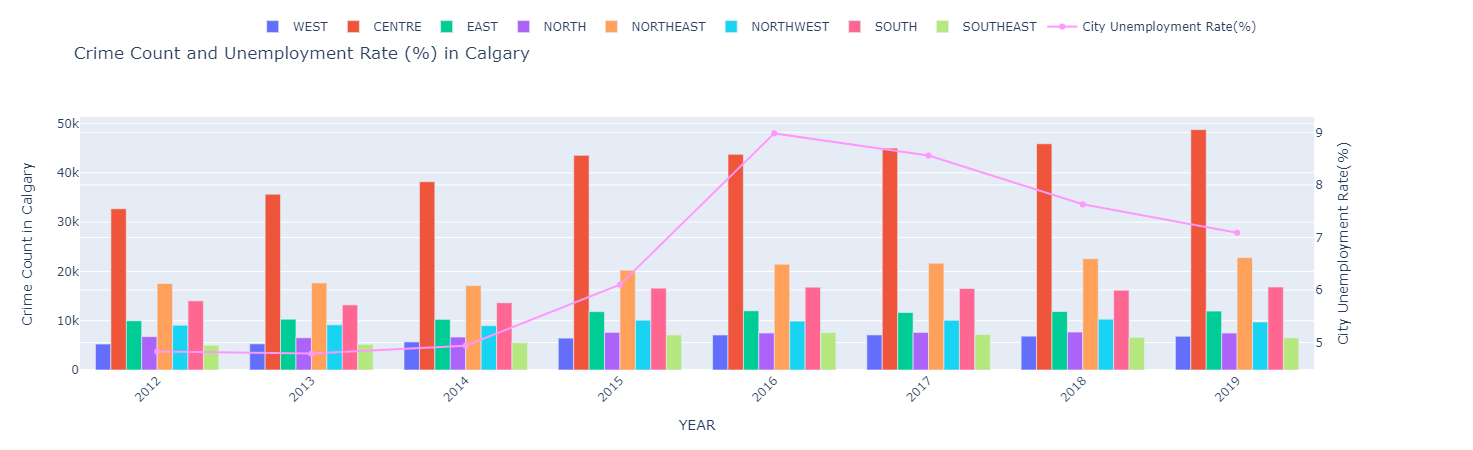

In [81]:
# Create figure with secondary y-axis
fig1 = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig1.add_trace(
    go.Bar(x= df1.YEAR.unique(), y = df1.loc[df1['SECTOR'] == 'WEST'].CRIME_COUNT, name="WEST"),
    secondary_y=False,
)

#8 SECTORS

#1
fig1.add_trace(
    go.Bar(x= df1.YEAR.unique(), y = df1.loc[df1['SECTOR'] == 'CENTRE'].CRIME_COUNT, name="CENTRE"),
    secondary_y=False,
)

#2
fig1.add_trace(
    go.Bar(x= df1.YEAR.unique(), y = df1.loc[df1['SECTOR'] == 'EAST'].CRIME_COUNT, name="EAST"),
    secondary_y=False,
)

#3
fig1.add_trace(
    go.Bar(x= df1.YEAR.unique(), y = df1.loc[df1['SECTOR'] == 'NORTH'].CRIME_COUNT, name="NORTH"),
    secondary_y=False,
)

#4
fig1.add_trace(
    go.Bar(x= df1.YEAR.unique(), y = df1.loc[df1['SECTOR'] == 'NORTHEAST'].CRIME_COUNT, name="NORTHEAST"),
    secondary_y=False,
)

#5
fig1.add_trace(
    go.Bar(x= df1.YEAR.unique(), y = df1.loc[df1['SECTOR'] == 'NORTHWEST'].CRIME_COUNT, name="NORTHWEST"),
    secondary_y=False,
)

#6
fig1.add_trace(
    go.Bar(x= df1.YEAR.unique(), y = df1.loc[df1['SECTOR'] == 'SOUTH'].CRIME_COUNT, name="SOUTH"),
    secondary_y=False,
)

#7
fig1.add_trace(
    go.Bar(x= df1.YEAR.unique(), y = df1.loc[df1['SECTOR'] == 'SOUTHEAST'].CRIME_COUNT, name="SOUTHEAST"),
    secondary_y=False,
)


#ADD Unemployment Rate Trace
fig1.add_trace(
    go.Scatter(x=df1.YEAR.unique(), y=df1.loc[df1['SECTOR'] == 'CENTRE'].CITY_UNEMPLOYMENT, name="City Unemployment Rate(%)"),
    secondary_y=True,
)

# Add figure title
fig1.update_layout(
    title_text="Crime Count and Unemployment Rate (%) in Calgary"
)

# Set x-axis title
fig1.update_xaxes(title_text="YEAR")

# Set y-axes titles
fig1.update_yaxes(title_text="Crime Count in Calgary", secondary_y=False)
fig1.update_yaxes(title_text="City Unemployment Rate(%)", secondary_y=True)

#SET MODE
fig1.update_layout(barmode='group', xaxis_tickangle=-45, xaxis={'categoryorder':'category descending'},
                  legend=dict(
                    orientation="h",
                    yanchor="bottom",
                    y=1.3,
                    xanchor="right",
                    x=0.9))
fig1.show()



In [7]:
display(df2)

,YEAR,COMMUNITY_NAME,CRIME_COUNT,CITY_UNEMPLOYMENT
0,2012,01B,1.0,4.83
1,2012,01B,4.0,4.83
2,2012,01B,5.0,4.83
3,2012,01B,1.0,4.83
4,2012,01B,1.0,4.83
...,...,...,...,...
16739,2019,WOODLANDS,334.0,7.09
16740,2019,WOODLANDS,1.0,7.09
16741,2019,WOODLANDS,29.0,7.09
16742,2019,WOODLANDS,22.0,7.09


In [8]:
display(df3)

,YEAR,AVG_RE_ASSESSED_VALUE,CITY_UNEMPLOYMENT,CITY_TOTAL_HOUSING_STARTS,CITY_INFLATION_RATE
0,2012,654642.25,4.83,12841.0,1.89
1,2013,620946.74,4.79,12584.0,1.08
2,2014,669136.28,4.94,17131.0,2.65
3,2015,715513.69,6.10,13033.0,1.84
4,2016,742130.08,8.98,9245.0,1.29
5,2017,694261.44,8.56,11534.0,1.20
6,2018,641814.04,7.63,10971.0,2.01
7,2019,673862.97,7.09,11909.0,1.89


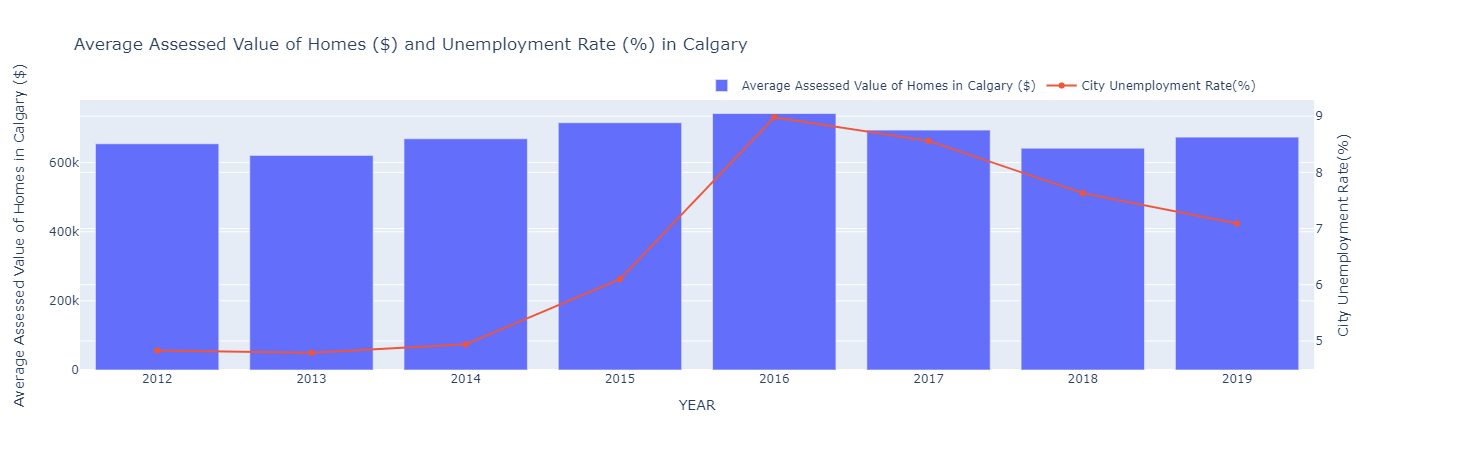

In [70]:
# Create figure with secondary y-axis
fig3 = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig3.add_trace(
    go.Bar(x= df3.YEAR, y=df3.AVG_RE_ASSESSED_VALUE, name="Average Assessed Value of Homes in Calgary ($)"),
    secondary_y=False,
)

fig3.add_trace(
    go.Scatter(x=df3.YEAR, y=df3.CITY_UNEMPLOYMENT, name="City Unemployment Rate(%)"),
    secondary_y=True,
)

# Add figure title
fig3.update_layout(
    title_text="Average Assessed Value of Homes ($) and Unemployment Rate (%) in Calgary",
     legend=dict(   orientation="h",
                    yanchor="bottom",
                    y=1.0,
                    xanchor="right",
                    x=0.9)
)

# Set x-axis title
fig3.update_xaxes(title_text="YEAR")

# Set y-axes titles
fig3.update_yaxes(title_text="Average Assessed Value of Homes in Calgary ($)", secondary_y=False)
fig3.update_yaxes(title_text="City Unemployment Rate(%)", secondary_y=True)

fig3.show()

In [9]:
display(df4)

,YEAR,AVG_RE_ASSESSED_VALUE,SECTOR,CITY_UNEMPLOYMENT,CITY_TOTAL_HOUSING_STARTS,CITY_INFLATION_RATE
0,2012,627699.983165,CENTRE,4.83,12841.0,1.89
1,2013,697308.716556,CENTRE,4.79,12584.0,1.08
2,2014,735468.241599,CENTRE,4.94,17131.0,2.65
3,2015,810426.708176,CENTRE,6.10,13033.0,1.84
4,2016,809743.299854,CENTRE,8.98,9245.0,1.29
...,...,...,...,...,...,...
59,2015,569446.411546,WEST,6.10,13033.0,1.84
60,2016,590344.325577,WEST,8.98,9245.0,1.29
61,2017,548711.622932,WEST,8.56,11534.0,1.20
62,2018,555065.086098,WEST,7.63,10971.0,2.01


In [44]:
#How to pull specific rows from dataframe that meets a condition
df4.loc[df4['SECTOR'] == 'WEST']

#GETTING unique SECTORS
df4.SECTOR.unique()

array(['CENTRE', 'EAST', 'NORTH', 'NORTHEAST', 'NORTHWEST', 'SOUTH',
       'SOUTHEAST', 'WEST'], dtype=object)

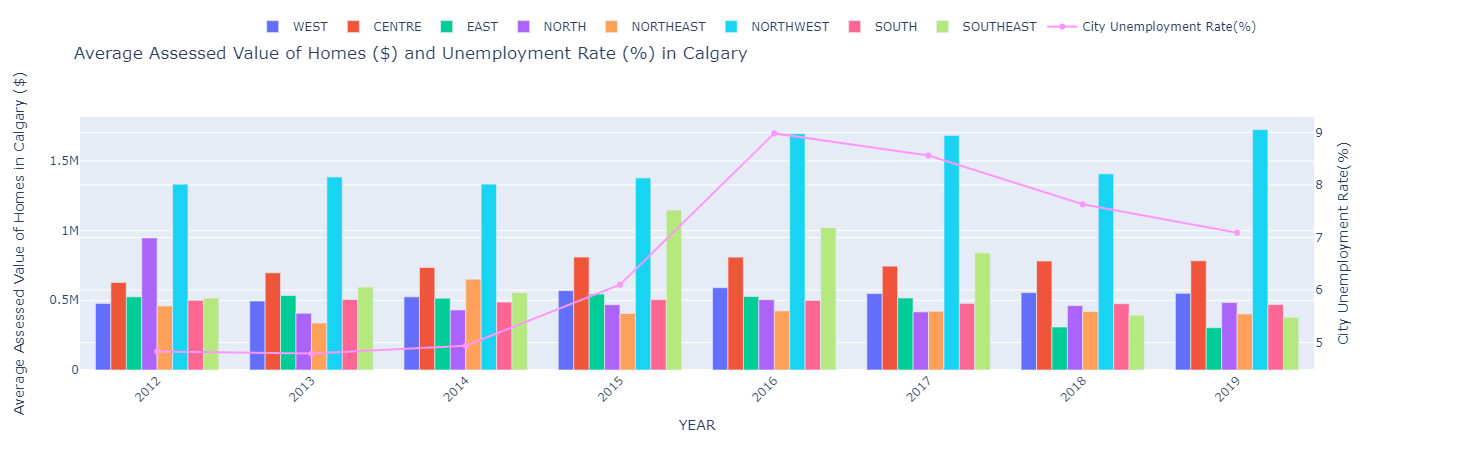

In [82]:
# Create figure with secondary y-axis
fig4 = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig4.add_trace(
    go.Bar(x= df4.YEAR, y = df4.loc[df4['SECTOR'] == 'WEST'].AVG_RE_ASSESSED_VALUE, name="WEST"),
    secondary_y=False,
)

#8 SECTORS

#1
fig4.add_trace(
    go.Bar(x= df4.YEAR, y = df4.loc[df4['SECTOR'] == 'CENTRE'].AVG_RE_ASSESSED_VALUE, name="CENTRE"),
    secondary_y=False,
)

#2
fig4.add_trace(
    go.Bar(x= df4.YEAR, y = df4.loc[df4['SECTOR'] == 'EAST'].AVG_RE_ASSESSED_VALUE, name="EAST"),
    secondary_y=False,
)

#3
fig4.add_trace(
    go.Bar(x= df4.YEAR, y = df4.loc[df4['SECTOR'] == 'NORTH'].AVG_RE_ASSESSED_VALUE, name="NORTH"),
    secondary_y=False,
)

#4
fig4.add_trace(
    go.Bar(x= df4.YEAR, y = df4.loc[df4['SECTOR'] == 'NORTHEAST'].AVG_RE_ASSESSED_VALUE, name="NORTHEAST"),
    secondary_y=False,
)

#5
fig4.add_trace(
    go.Bar(x= df4.YEAR, y = df4.loc[df4['SECTOR'] == 'NORTHWEST'].AVG_RE_ASSESSED_VALUE, name="NORTHWEST"),
    secondary_y=False,
)

#6
fig4.add_trace(
    go.Bar(x= df4.YEAR, y = df4.loc[df4['SECTOR'] == 'SOUTH'].AVG_RE_ASSESSED_VALUE, name="SOUTH"),
    secondary_y=False,
)

#7
fig4.add_trace(
    go.Bar(x= df4.YEAR, y = df4.loc[df4['SECTOR'] == 'SOUTHEAST'].AVG_RE_ASSESSED_VALUE, name="SOUTHEAST"),
    secondary_y=False,
)


#ADD Unemployment Rate Trace
fig4.add_trace(
    go.Scatter(x=df4.YEAR, y=df4.loc[df4['SECTOR'] == 'CENTRE'].CITY_UNEMPLOYMENT, name="City Unemployment Rate(%)"),
    secondary_y=True,
)

# Add figure title
fig4.update_layout(
    title_text="Average Assessed Value of Homes ($) and Unemployment Rate (%) in Calgary"
)

# Set x-axis title
fig4.update_xaxes(title_text="YEAR")

# Set y-axes titles
fig4.update_yaxes(title_text="Average Assessed Value of Homes in Calgary ($)", secondary_y=False)
fig4.update_yaxes(title_text="City Unemployment Rate(%)", secondary_y=True)

#SET MODE
fig4.update_layout(barmode='group', xaxis_tickangle=-45, xaxis={'categoryorder':'category descending'},
                   legend=dict(
                    orientation="h",
                    yanchor="bottom",
                    y=1.3,
                    xanchor="right",
                    x=0.9))
fig4.show()




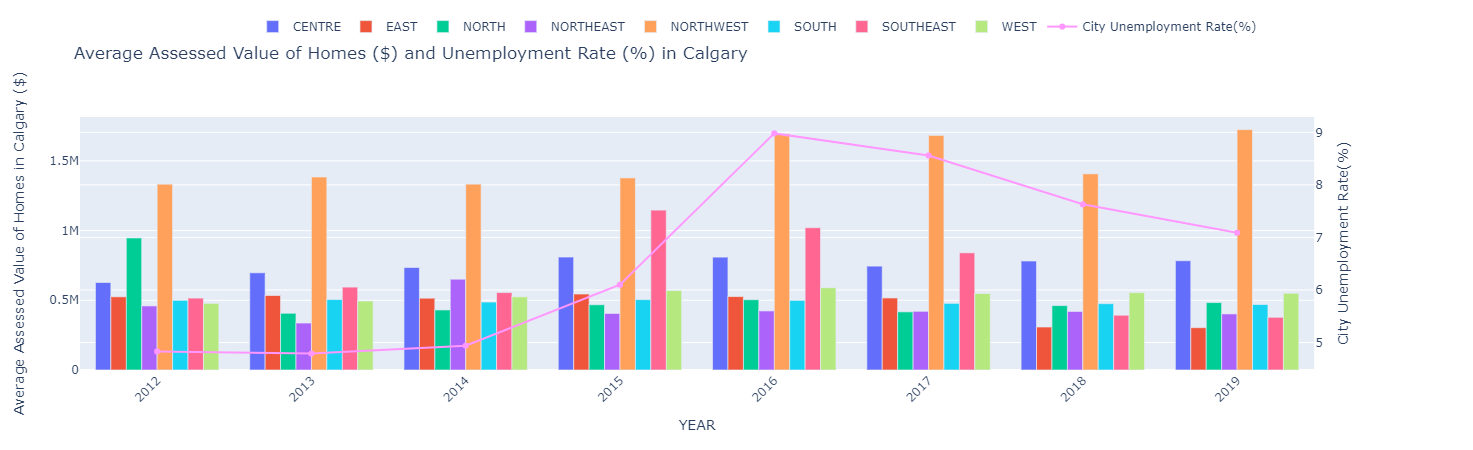

In [88]:
#MORE PYTHONIC WAY
# Create figure with secondary y-axis
fig4 = make_subplots(specs=[[{"secondary_y": True}]])

sectors = df4.SECTOR.unique()

for sector in sectors:
    # Add traces
    fig4.add_trace(
        go.Bar(x= df4.YEAR, y = df4.loc[df4['SECTOR'] == sector].AVG_RE_ASSESSED_VALUE, name=sector),
        secondary_y=False,)
    

#ADD Unemployment Rate Trace
fig4.add_trace(
    go.Scatter(x=df4.YEAR, y=df4.loc[df4['SECTOR'] == 'CENTRE'].CITY_UNEMPLOYMENT, name="City Unemployment Rate(%)"),
    secondary_y=True,
)

# Add figure title
fig4.update_layout(
    title_text="Average Assessed Value of Homes ($) and Unemployment Rate (%) in Calgary"
)

# Set x-axis title
fig4.update_xaxes(title_text="YEAR")

# Set y-axes titles
fig4.update_yaxes(title_text="Average Assessed Value of Homes in Calgary ($)", secondary_y=False)
fig4.update_yaxes(title_text="City Unemployment Rate(%)", secondary_y=True)

#SET MODE
fig4.update_layout(barmode='group', xaxis_tickangle=-45, xaxis={'categoryorder':'category descending'},
                   legend=dict(
                    orientation="h",
                    yanchor="bottom",
                    y=1.3,
                    xanchor="right",
                    x=0.9))
fig4.show()


In [57]:
display(df5)
df5.columns.unique()

,YEAR,CITY_UNEMPLOYMENT,ASSAULT,COMM_B_AND_E,RES_B_AND_E,THEFT_FROM_VEHICLE,THEFT_OF_VEHICLE
0,2012,4.83,2284.0,2028.0,3276.0,7619.0,2932.0
1,2013,4.79,2313.0,1939.0,3392.0,7381.0,3386.0
2,2014,4.94,2398.0,1949.0,3683.0,6889.0,3010.0
3,2015,6.10,2392.0,3358.0,5332.0,10820.0,4878.0
4,2016,8.98,2597.0,3262.0,4646.0,11882.0,5187.0
5,2017,8.56,2955.0,3983.0,3892.0,11150.0,5922.0
6,2018,7.63,3546.0,4545.0,4401.0,11033.0,5848.0
7,2019,7.09,3614.0,5276.0,4290.0,13332.0,5855.0


Index(['YEAR', 'CITY_UNEMPLOYMENT', 'ASSAULT', 'COMM_B_AND_E', 'RES_B_AND_E',
       'THEFT_FROM_VEHICLE', 'THEFT_OF_VEHICLE'],
      dtype='object')

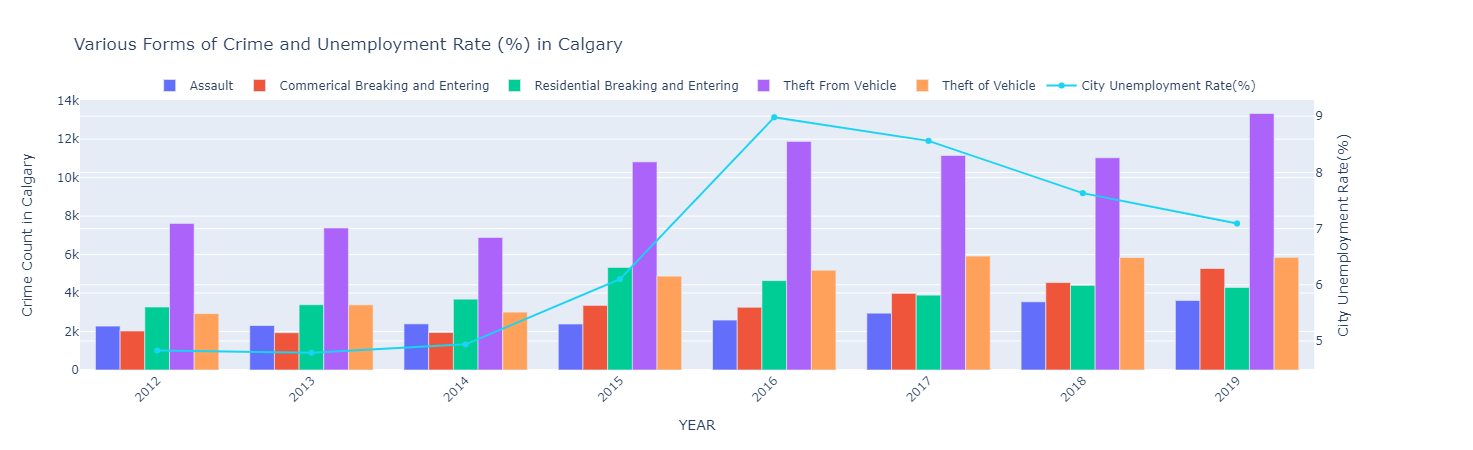

In [75]:
# Create figure with secondary y-axis
fig5 = make_subplots(specs=[[{"secondary_y": True}]])

#DIFFERENT KINDS OF CRIME
#1
fig5.add_trace(
    go.Bar(x= df5.YEAR, y = df5.ASSAULT, name="Assault"),
    secondary_y=False,
)

#2
fig5.add_trace(
    go.Bar(x= df5.YEAR, y = df5.COMM_B_AND_E, name="Commerical Breaking and Entering"),
    secondary_y=False,
)

#3
fig5.add_trace(
    go.Bar(x= df5.YEAR, y = df5.RES_B_AND_E, name="Residential Breaking and Entering"),
    secondary_y=False,
)
#4
fig5.add_trace(
    go.Bar(x= df5.YEAR, y = df5.THEFT_FROM_VEHICLE, name="Theft From Vehicle"),
    secondary_y=False,
)

#5
fig5.add_trace(
    go.Bar(x= df5.YEAR, y = df5.THEFT_OF_VEHICLE, name="Theft of Vehicle"),
    secondary_y=False,
)


#ADD Unemployment Rate Trace
fig5.add_trace(
    go.Scatter(x=df5.YEAR, y=df5.CITY_UNEMPLOYMENT, name="City Unemployment Rate(%)"),
    secondary_y=True,
)

# Add figure title
fig5.update_layout(
    title_text="Various Forms of Crime and Unemployment Rate (%) in Calgary"
)

# Set x-axis title
fig5.update_xaxes(title_text="YEAR")

# Set y-axes titles
fig5.update_yaxes(title_text="Crime Count in Calgary", secondary_y=False)
fig5.update_yaxes(title_text="City Unemployment Rate(%)", secondary_y=True)

#SET MODE
fig5.update_layout(barmode='group', xaxis_tickangle=-45, xaxis={'categoryorder':'category descending'},
                   legend=dict(
                    orientation="h",
                    yanchor="bottom",
                    y=1.0,
                    xanchor="right",
                    x=0.9))
fig5.show()

In [84]:
#MORE PYTHONIC WAY, LESS REPEATS
df5.columns

Index(['YEAR', 'CITY_UNEMPLOYMENT', 'ASSAULT', 'COMM_B_AND_E', 'RES_B_AND_E',
       'THEFT_FROM_VEHICLE', 'THEFT_OF_VEHICLE'],
      dtype='object')

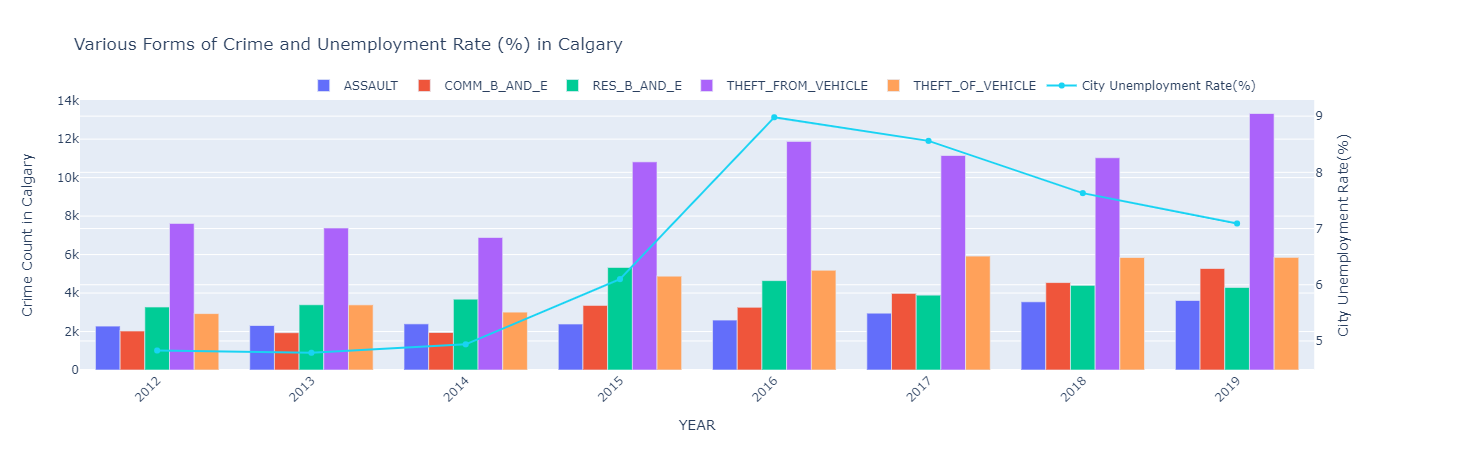

In [87]:
# Create figure with secondary y-axis
fig5 = make_subplots(specs=[[{"secondary_y": True}]])

#MORE PYTHONIC WAY, for loop for all crime types (columns)
for crime in df5.columns[2:]:
    
    fig5.add_trace(
    go.Bar(x= df5.YEAR, y = df5[crime], name=crime),
    secondary_y=False,)

#ADD Unemployment Rate Trace
fig5.add_trace(
    go.Scatter(x=df5.YEAR, y=df5.CITY_UNEMPLOYMENT, name="City Unemployment Rate(%)"),
    secondary_y=True,
)

# Add figure title
fig5.update_layout(
    title_text="Various Forms of Crime and Unemployment Rate (%) in Calgary"
)

# Set x-axis title
fig5.update_xaxes(title_text="YEAR")

# Set y-axes titles
fig5.update_yaxes(title_text="Crime Count in Calgary", secondary_y=False)
fig5.update_yaxes(title_text="City Unemployment Rate(%)", secondary_y=True)

#SET MODE
fig5.update_layout(barmode='group', xaxis_tickangle=-45, xaxis={'categoryorder':'category descending'},
                   legend=dict(
                    orientation="h",
                    yanchor="bottom",
                    y=1.0,
                    xanchor="right",
                    x=0.9))
fig5.show()